<a href="https://colab.research.google.com/github/andreytsimbalov/News_Classification_and_Vectorization/blob/main/vector_model_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn.cluster as sc
import gensim
import random
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
main_tags_list = ['economy',
 'entertainment',
 'traditions',
 'science',
 'society',
 'sports',
 'technology']

main_tags_dict = {0: 'economy',
 1: 'entertainment',
 2: 'traditions',
 3: 'science',
 4: 'society',
 5: 'sports',
 6: 'technology'}

In [ ]:
months = {
    'января':'01',
    'февраля':'02',
    'марта':'03',
    'апреля':'04',
    'мая':'05',
    'июня':'06',
    'июля':'07',
    'августа':'08',
    'сентября':'09',
    'октября':'10',
    'ноября':'11',
    'декабря':'12'
}
months_numbers = list(months.values())

# Извлечение данных для обучения


In [ ]:
# для предобработанного текста
def load_data_to_list_of_dict(path):

  df  = pd.read_pickle(path)
  label = df.label.to_numpy()
  text = df.text.to_numpy()
  return [{"id": i,"label": l,"text": t, } for i, l, t in zip(range(len(label)),label,text)]

path = md + 'data/data_lemm'
# path = md + 'data/data_stem'
data_text = load_data_to_list_of_dict(path)
data_text_text = [d['text'] for d in data_text]
len(data_text), data_text[4]

(151841,
 {'id': 4,
  'label': 1,
  'text': 'анастасия заворотнюк поблагодарить россиянин поддержка актриса анастасия заворотнюк канун новый год поблагодарить поддерживать молиться весь настя передавать огромный привет благодарить поддержка ваш молитва душевный тепло который дарита отмечаться сообщение инстаграм артистка автор публикация также передавать пожелание здоровье благополучие заворотнюк семья пусть следующий год стать счастливый пусть исполнить ваш самый главный желание говориться пост новость серьёзный заболевание заворотнюк начать появляться конец лето число_год_2019 год некоторый сми сообщить диагностировать раковый опухоль мозг семья актриса долго комментировать информация затем подтвердить действительно проходить лечение '})

In [ ]:
# для НЕпредобработанного текста
def load_data_to_list_of_dict(path):

  df  = pd.read_pickle(path)
  label = df.label.to_numpy()
  text = df.main_text.to_numpy()
  return [{"id": i,"label": l,"text": t, } for i, l, t in zip(range(len(label)),label,text)]

path = md + 'data/news_main_2020'
data_text = load_data_to_list_of_dict(path)
data_text_text = [d['text'] for d in data_text]
len(data_text), data_text[4]

(151841,
 {'id': 4,
  'label': 1,
  'text': 'Анастасия Заворотнюк поблагодарила россиян за поддержку. Актриса Анастасия Заворотнюк в канун Нового года поблагодарила всех, кто ее поддерживал и молился за нее. "Всем вам Настя передает огромный привет и благодарит за поддержку, за ваши молитвы и то душевное тепло, которое вы дарите", — отмечается в сообщении в инстаграме артистки. Автор публикации также передает пожелания здоровья и благополучия от Заворотнюк и ее семьи. "Пусть следующий год станет счастливым, пусть он исполнит ваши самые главные желания!" — говорится в посте. Новости о серьезном заболевании Заворотнюк начали появляться в конце лета 2019 года. Некоторые СМИ сообщили, что у нее диагностировали раковую опухоль мозга. Семья актрисы долго не комментировала эту информацию, однако затем подтвердила, что она действительно проходит лечение. '})

In [ ]:
main_tags_counter_dict = dict(zip(list(main_tags_dict.keys()), np.zeros(len(list(main_tags_dict.values())))))
for dt in data_text:
  if dt['label']!=-1:
    main_tags_counter_dict[dt['label']]+=1
main_tags_counter_dict

{0: 11803.0,
 1: 6389.0,
 2: 11322.0,
 3: 6782.0,
 4: 20141.0,
 5: 8673.0,
 6: 4845.0}

# wordcloud самых частотных слов

In [ ]:
data = pd.read_pickle(md+'data/news_main_2020')

In [ ]:
data.head()

,tags,dt,main_text,website
0,[Экономика],2020-01-01 00:07:00,В России повысили зарплаты. В России повышен м...,lenta
1,[Бывший СССР],2020-01-01 00:27:00,Партия Порошенко потребовала запретить поставк...,lenta
2,"[Новый год—2020, Парковка, Москва, Общество]",2020-01-01 00:33:00,Парковка в Москве в новогодние праздники будет...,ria
3,[Экономика],2020-01-01 00:35:00,В России подорожали алкогольные напитки и сига...,lenta
4,"[Новый год—2020, Шоу-бизнес, Анастасия Заворот...",2020-01-01 00:38:00,Анастасия Заворотнюк поблагодарила россиян за ...,ria


In [ ]:
from wordcloud import WordCloud

# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              # stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [ ]:
corpus = get_corpus(data['main_text'][:100].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
data = pd.read_pickle(md+'data/data_lemm')

In [ ]:
corpus = []
for dt in data.text[:1000]:
  for word in dt.split(' '):
    corpus.extend([word])
len(corpus)

149367

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


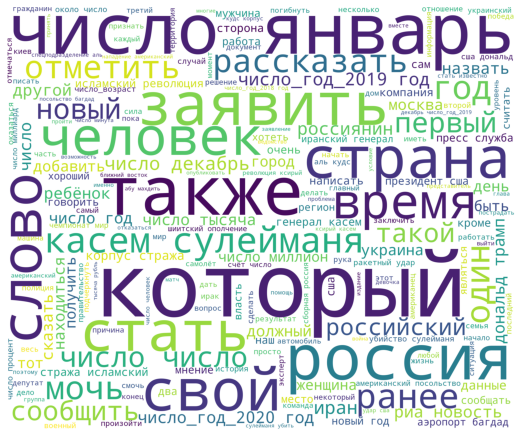

In [ ]:
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

# Векторизаторы

# Tfidf model


**подготовка текста к tfidf и создание label**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5, max_features = 500000)#, max_features = 100000
%time X_idf = tfidf.fit_transform([dtt['text'] for dtt in data_text_tfidf])
# X_test_idf = tfidf.transform(X_test_idf_text)
X_idf.shape

CPU times: user 1min 32s, sys: 1.47 s, total: 1min 34s
Wall time: 1min 34s


(151841, 500000)

In [ ]:
pickle.dump(tfidf, open(md+"models/tfidf_lemm_500k.pickle", "wb"))

# Word2Vec model

In [ ]:
data = pd.read_pickle(md+'data/news_main_prepr_2020')

In [ ]:
data_train = []
for dlt in list(data.lemm_text):
  data_train.extend(dlt)
len(data_train)

2112888

In [ ]:
import gensim
%time w2v = gensim.models.Word2Vec(
    data_train, 
    size=300,
    workers=8, 
    iter=20, 
    min_count = 5,
    window = 10,
    sg=1, 
    sample=0.0001)
w2v.save(md+'models/w2v_lemm_300.model')


CPU times: user 2h 1min 39s, sys: 11.8 s, total: 2h 1min 50s
Wall time: 1h 1min 54s


# Doc2Vec model

In [ ]:
data = pd.read_pickle(md+'data/news_main_prepr_2020')

In [ ]:
data_train = []
for dlt in data.lemm_text:
  ddd = []
  for dlt_i in dlt:
    ddd.extend(dlt_i)
  data_train.extend([ddd])
len(data_train)

151841

In [ ]:
tagged_data = [gensim.models.doc2vec.TaggedDocument(_d, [i]) for i, _d in enumerate(data_train)]
%time d2v = gensim.models.doc2vec.Doc2Vec(documents = tagged_data, workers=8,\
                                          dm=0, vector_size=300,  \
                                          min_count=5, sample = 0.0001)
d2v.save(md+'models/d2v_300.model')

CPU times: user 8min 33s, sys: 19.2 s, total: 8min 53s
Wall time: 5min 33s


In [ ]:
gensim.models.doc2vec.Doc2Vec()

# FastText model

In [ ]:
data = pd.read_pickle(md+'data/news_main_prepr_2020')
data_train = []
for dlt in list(data.lemm_text):
  data_train.extend(dlt)
del data
len(data_train)

2112888

In [ ]:
import gensim
%time ft = gensim.models.FastText(
    sentences=data_train,
    size = 300,
    sg = 1, 
    sample = 0.0001,
    workers=8, 
    iter = 20, 
    window = 10)
ft.save(md+'models/ft_lemm_300.model')

CPU times: user 5h 30min 3s, sys: 24.2 s, total: 5h 30min 28s
Wall time: 2h 47min 38s


# GloVe & Tfidf to model

In [ ]:
!pip install navec slovnet

     |████████████████████████████████| 51kB 4.2MB/s 


In [ ]:
import torch

from navec import Navec
from slovnet.model.emb import NavecEmbedding

In [ ]:
path = 'models/navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(md + path)  # ~1 sec, ~100MB RAM

In [ ]:
tfidf = pickle.load(open(md+"models/tfidf_lemm_500k.pickle", "rb"))
tfidf_words = tfidf.get_feature_names()
tfidf_dict = dict(zip(tfidf_words, tfidf.idf_))

In [ ]:
def word_embedding_glove_with_tfidf(text):
  # векторизация слов в тексте с tfidf
  word_embedd = []
  nav_emb = NavecEmbedding(navec)
  for text_i in tqdm(text):
    we = np.zeros(len(nav_emb(torch.tensor(0))))
    count = 0
    for word in text_i.split():
      try:
        tfidf_koeff = tfidf_dict[word]
        word_tensor_vec = nav_emb(torch.tensor(navec.vocab[word]))
        we += np.array(word_tensor_vec) * tfidf_koeff
        count+=1
      except:
        pass
    if count!=0:
      we = we / count
    word_embedd.extend([we])
  return word_embedd

x_test_data = word_embedding_glove_with_tfidf(data_text_text[:100])

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
data_text_text[0]

'россия повысить зарплата россия повысить минимальный размер оплата труд мрот соответствовать закон конец декабрь подписать президент владимир путин повышение составить число рубль число процент число январь федеральный мрот трудоспособный население составлять число рубль месяц закон размер мрот устанавливаться ежегодно ниже величина прожиточный минимум второй квартал предыдущий год порядок действовать число_год_2018 год путин декабрь пообещать подумать изменение правило польза увеличение мрот размер подоходный налог который учитываться человек получать зарплата выше уровень мрот который вычет налог опускаться ниже '

In [ ]:
len(x_test_data[0])

300

In [ ]:
X_data = word_embedding_glove_with_tfidf(data_text_text)

In [ ]:
pickle.dump(X_data, open(md+"models/glove_tfidf_vector_data.pickle", "wb"))

# Word2Vec & Tfidf to vector


In [ ]:
w2v = gensim.models.Word2Vec.load(md+"models/w2v_lemm_300.model")

In [ ]:
tfidf = pickle.load(open(md+"models/tfidf_lemm_500k.pickle", "rb"))
tfidf_words = tfidf.get_feature_names()
tfidf_dict = dict(zip(tfidf_words, tfidf.idf_))

In [ ]:
def word_embedding_with_tfidf(text):
  # векторизация слов в тексте с tfidf
  word_embedd = []
  for text_i in tqdm(text):
    we = np.zeros(w2v.wv.vector_size)
    count = 0
    for word in text_i.split():
      try:
        tfidf_koeff = tfidf_dict[word]
        we += w2v.wv[word] * tfidf_koeff
        count+=1
      except:
        pass
    if count!=0:
      we = we / count
    word_embedd.extend([we])
  return word_embedd

x_test_data = word_embedding_with_tfidf(data_text_text[:100])

In [ ]:
len(x_test_data[0])

300

In [ ]:
x_test_data

In [ ]:
X_vectors = word_embedding_with_tfidf(data_text_text)

In [ ]:
len(X_vectors)

151841

In [ ]:
pickle.dump(X_vectors, open(md+"models/w2v_tfidf_vector_data.pickle", "wb"))

# Universal Sentence Encoder

https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/


In [ ]:
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

     |████████████████████████████████| 454.3MB 38kB/s 
     |████████████████████████████████| 4.0MB 32.9MB/s 
     |████████████████████████████████| 471kB 35.0MB/s 
     |████████████████████████████████| 4.0MB 11.9MB/s 
     |████████████████████████████████| 6.0MB 27.9MB/s 
     |████████████████████████████████| 1.2MB 29.7MB/s 
     |████████████████████████████████| 4.9MB 18.1MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: ten

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 4.4MB/s 
     |████████████████████████████████| 471kB 32.0MB/s 
     |████████████████████████████████| 2.9MB 33.6MB/s 
     |████████████████████████████████| 3.8MB 35.3MB/s 
ERROR: tensorflow-gpu 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installat

In [ ]:
!pip install -U tensorflow==2.3.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import numpy as np

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3 loaded


In [ ]:
import tensorflow_hub as hub

embed = hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3" )

embedding = embed(
    ["съешь ещё этих мягких французских булок, да выпей чаю"])

In [ ]:
n=5
max_sent_len = 5000
step = int(len(data_text_text)/n)
for i in tqdm(range(n)):
  start=step*i
  fin = step*(i+1)
  if i+1 == n:
    fin+=1
  print(start, fin)
  
  use_vectors = []
  for dtt in tqdm(data_text_text[start: fin]):
    if len(dtt.split())>max_sent_len:
      dtt_item = ''
      for dtt_i in dtt.split()[:max_sent_len]:
        dtt_item+=dtt_i
      dtt = dtt_item
      del dtt_item
    use_vectors.append(np.array(model([dtt])[0], dtype = np.float16))

  print(len(use_vectors))
  pickle.dump(use_vectors, open(md+"models/use_vector_data_" + str(i) + ".pickle", "wb"))

91104 121472



30368
121472 151841



30369



In [ ]:
use_vectors = []
for i in tqdm(range(n)):
  qwe = pickle.load(open(md+"models/use_vector_data_"+str(i)+".pickle", "rb"))
  use_vectors.extend(qwe)
len(use_vectors)

151841

In [ ]:
pickle.dump(use_vectors, open(md+"models/use_vector_data.pickle", "wb"))

In [ ]:
n=5
step = int(len(data_text_text)/n)
counter=0
for i in tqdm(range(n)):
  use_vectors = []
  start=step*i
  fin = step*(i+1)
  if i+1 == n:
    fin+=1
  print(start, fin)
  for j in data_text_text[start: fin]:
    counter+=1

counter

0 30368
30368 60736
60736 91104
91104 121472
121472 151841



151841

In [ ]:
len(data_text_text)

151841

# Bert_trans

In [ ]:
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.7/dist-packages (2.5.0)
  Using cached https://files.pythonhosted.org/packages/9d/74/9eae2bedd8201ab464308f42c601a12d79727a1c87f0c867fdefb212c6cf/h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/78/b27f73e923becc6e79e18fe112cf75e3200d1ee35b0dba8fa46181bce56c/tensorflow_estimator-2.5.0-py2.py3-none-any.whl
     |████████████████████████████████| 14.8MB 207kB/s 
  Using cached https://files.pythonhosted.org/packages/d5/d1/f38a91d8724706427fe973a7dfa11e938cee98aa7196b03d870a25a08bab/grpcio-1.34.1-cp37-cp37m-manylinux2014_x86_64.whl
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.1

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 394.3MB 42kB/s 
  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/06/54/1c8be62beafe7fb1548d2968e518ca040556b46b0275399d4f3186c56d79/grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/74/7e/622d9849abf3afb81e482ffc170758742e392ee129ce1540611199a59237/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
ERROR: tensorflow-gpu 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement h5py~=3.1.0, but 

In [ ]:
!pip install -U tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 460kB 29.9MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
ERROR: tensorflow-text 2.4.3 has requirement tensorflow<2.5,>=2.4.0, but you'll have tensorflow 2.3.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: alb

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import numpy as np

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
                         trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

embedding_model = tf.keras.Model(text_input, pooled_output)

In [ ]:
n=5
max_sent_len = 5000
step = int(len(data_text_text)/n)
for i in tqdm(range(3)):
  start=step*i
  fin = step*(i+1)
  if i+1 == n:
    fin+=1
  print(start, fin)
  
  use_vectors = []
  for dtt in tqdm(data_text_text[start: fin]):
    if len(dtt.split())>max_sent_len:
      dtt_item = ''
      for dtt_i in dtt.split()[:max_sent_len]:
        dtt_item+=dtt_i
      dtt = dtt_item
      del dtt_item
    sentences = tf.constant([dtt])
    vec = np.array(embedding_model(sentences), dtype = np.float16)[0]
    use_vectors.append(vec)

  print(len(use_vectors))
  pickle.dump(use_vectors, open(md+"models/bert_vector_data_" + str(i) + ".pickle", "wb"))

0 30368



30368
30368 60736



30368
60736 91104



30368



In [ ]:
use_vectors = []
for i in tqdm(range(n)):
  qwe = pickle.load(open(md+"models/bert_vector_data_"+str(i)+".pickle", "rb"))
  use_vectors.extend(qwe)
len(use_vectors)

151841

In [ ]:
pickle.dump(use_vectors, open(md+"models/bert_vector_data.pickle", "wb"))